In [1]:
import sys
import os
sys.path.append("../..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from pyspark.sql.functions import *

import commembed.data as data
import commembed.analysis as analysis


spark = data.spark_context()

%load_ext autoreload
%autoreload 2

/u/walleris/miniconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Spark WebUI: http://ada.ais.sandbox:4042
Spark WebUI: http://ada.ais.sandbox:4042


In [2]:
partisan_dimen = "partisan"

In [3]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)

In [4]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)

neutral_cutoff = neutral_cutoffs

scores_filtered = scores[scores[partisan_dimen+'_neutral'] > neutral_cutoff[partisan_dimen]]
print("%d political subreddits selected" % len(scores_filtered))
scores_df = spark.createDataFrame(scores_filtered.reset_index())
scores_df.createOrReplaceTempView("scores")

682 political subreddits selected


In [5]:
data.load("all_objects_monthly_user_counts")

(Freshly loading table all_objects_monthly_user_counts)


DataFrame[author: string, subreddit: string, month: string, num_comments: bigint]

In [6]:
sub_data = spark.sql("""
    select subreddit, (all_objects_monthly_user_counts.author == '[deleted]') as deleted,
        sum(num_comments) as num_comments
    from all_objects_monthly_user_counts
    
    inner join scores
    on scores.community = all_objects_monthly_user_counts.subreddit

    group by 1, 2
""").toPandas()

In [9]:
sub_data = sub_data.set_index("subreddit")
sub_data["score"] = scores[partisan_dimen]
sub_data

,deleted,num_comments,score
subreddit,,,
MensRights,False,3957132,0.230913
MensRights,True,653067,0.230913
OurPresident,False,141078,0.060955
OurPresident,True,32852,0.060955
QuotesPorn,False,393605,0.067403
...,...,...,...
prolife,True,18949,0.032855
im14andthisisdeep,False,1358919,0.085840
im14andthisisdeep,True,108285,0.085840


<Figure size 432x288 with 0 Axes>

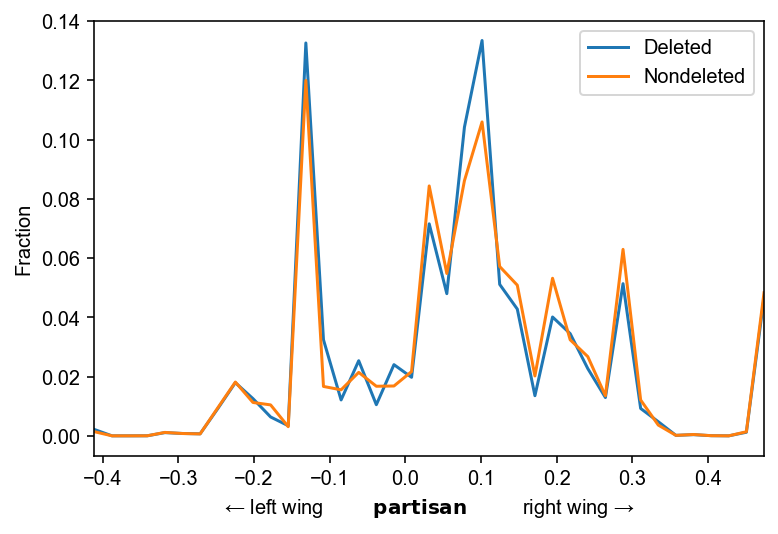

In [61]:
bins = np.linspace(np.amin(sub_data["score"]), np.amax(sub_data["score"]), 40)

dfs = [sub_data[sub_data["deleted"] == deleted] for deleted in [True, False]]
dists = [np.histogram(df["score"], weights=df["num_comments"], density=False, bins=bins)[0]/np.sum(df["num_comments"]) for df in dfs]

dist_df = pd.DataFrame({"Deleted":dists[0],"Nondeleted":dists[1]}, index=bins[:-1])

dist_df.to_csv("12_deleted_dist_df.csv")

plt.figure()
dist_df.plot.line()
from matplotlib.ticker import AutoLocator
plt.gca().xaxis.set_major_locator(AutoLocator())
from matplotlib.ticker import ScalarFormatter
plt.ylabel("Fraction")
plt.xlabel(axis_label("partisan"))
plt.show()

In [33]:
total_comments = np.sum(sub_data["num_comments"])
print(total_comments)
np.sum(dfs[1]["num_comments"]) / total_comments

983684649


0.8875681570181746

In [58]:
means = [np.sum(df["score"] * df["num_comments"]) / np.sum(df["num_comments"]) for df in dfs]
print(means)
print((means[0] - means[1]))
print((means[0] - means[1]) / np.std(scores[partisan_dimen]))

[0.08361833298207409, 0.09389180524477203]
-0.010273472262697939
-0.11244724962937751


In [59]:
P = dists[1]
Q = dists[0]

np.sum(P * np.nan_to_num(np.log2(P / (Q)), nan=0))

/u/walleris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0.033408862639773704